In [1]:
import sys,os
from pathlib import Path
sys.path.append(str(Path("../")))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
from utils import loaders,model_body


NUM_GPU=torch.cuda.device_count()
EPOCHS=500
NITER=20
#-------------------------------------Loader Building---------------------------------
                 
IMG_ROOT="../data/anime"
OUT_DIR="../model_body"
os.makedirs(OUT_DIR, exist_ok = True)
#-------------------------------------Loader Building---------------------------------
train_set=loaders.CostumImFolder([IMG_ROOT+"/train_img/"],
                                 [IMG_ROOT+"/train_label/"],ifbody=True,ifhead=False)

train_loader=DataLoader(train_set, batch_size=2, shuffle=True,num_workers = 4*NUM_GPU,pin_memory=True)

print(train_set.transform)
GAN_DIM=24+5+5+1
HEAD_GAN_DIM=14+1

#-------------------------------------Model Building---------------------------------
G=torch.load(OUT_DIR+"/netGbody_struct.pth").cuda()
#-------------------------------------Model Training---------------------------------
G.load_state_dict(torch.load(OUT_DIR+"/netGbody_run220.pt"))

Compose(
    Lambda()
    ToTensor()
    <class 'torch.FloatTensor'>
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [10]:
out_img[0].shape

torch.Size([512, 512, 3])

In [ ]:
from cv2 import imread

In [2]:
with torch.no_grad():
    for in_img,lbl_sample,_,_,_ in train_loader:
        ############### Forward ####################
        out_img = G(torch.tensor(lbl_sample,dtype=torch.float32, device=torch.device('cuda:0')))
        break
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


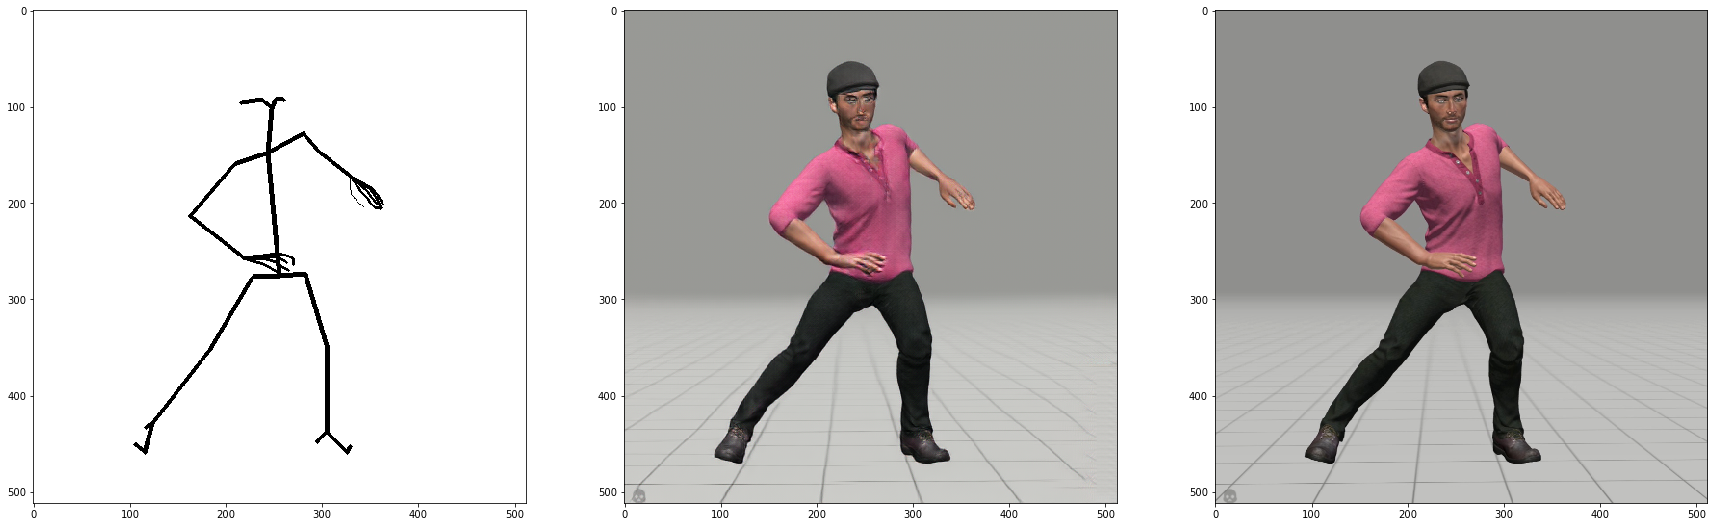

In [4]:
BATC=1
def norm_0to1(inp):
    return (inp-inp.min())/(inp.max()-inp.min())
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize=(30,60))


plt.subplot(1,3,1)
plt.imshow(norm_0to1(lbl_sample[BATC,34,...]).detach().cpu().numpy(),"gray")
plt.subplot(1,3,2)
plt.imshow(norm_0to1(out_img[BATC,...].detach().cpu().numpy().transpose(1,2,0)))
plt.subplot(1,3,3)
plt.imshow(norm_0to1(in_img[BATC,...]).detach().cpu().numpy().transpose(1,2,0))
plt.show()

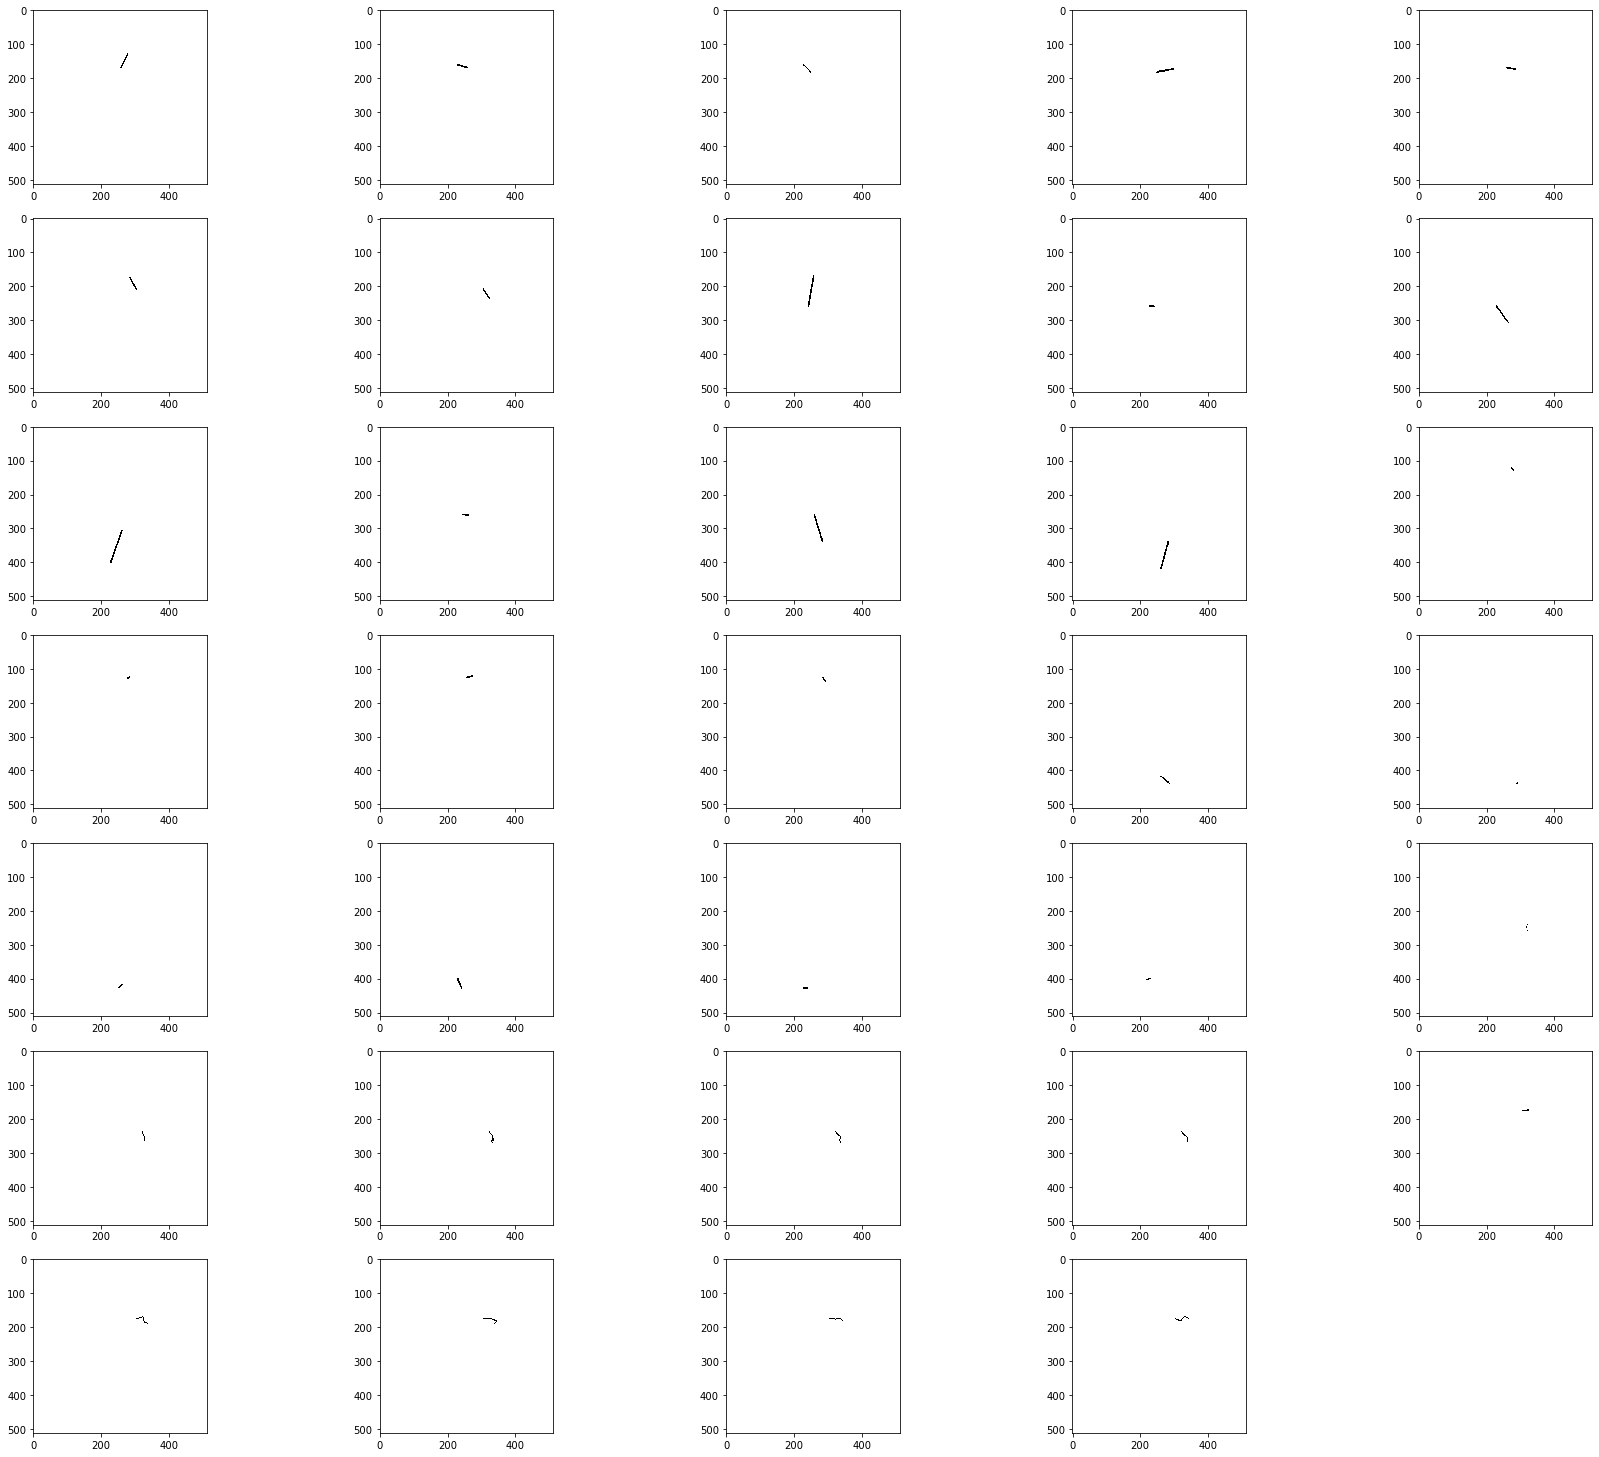

In [17]:
BATC=1
def norm_0to1(inp):
    return (inp-inp.min())/(inp.max()-inp.min())
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize=(30,30))
for ii in range(34):
    plt.subplot(8,5,ii+1)
    plt.imshow(1-norm_0to1(lbl_sample[BATC,ii,...]).detach().cpu().numpy(),"gray")
plt.show()

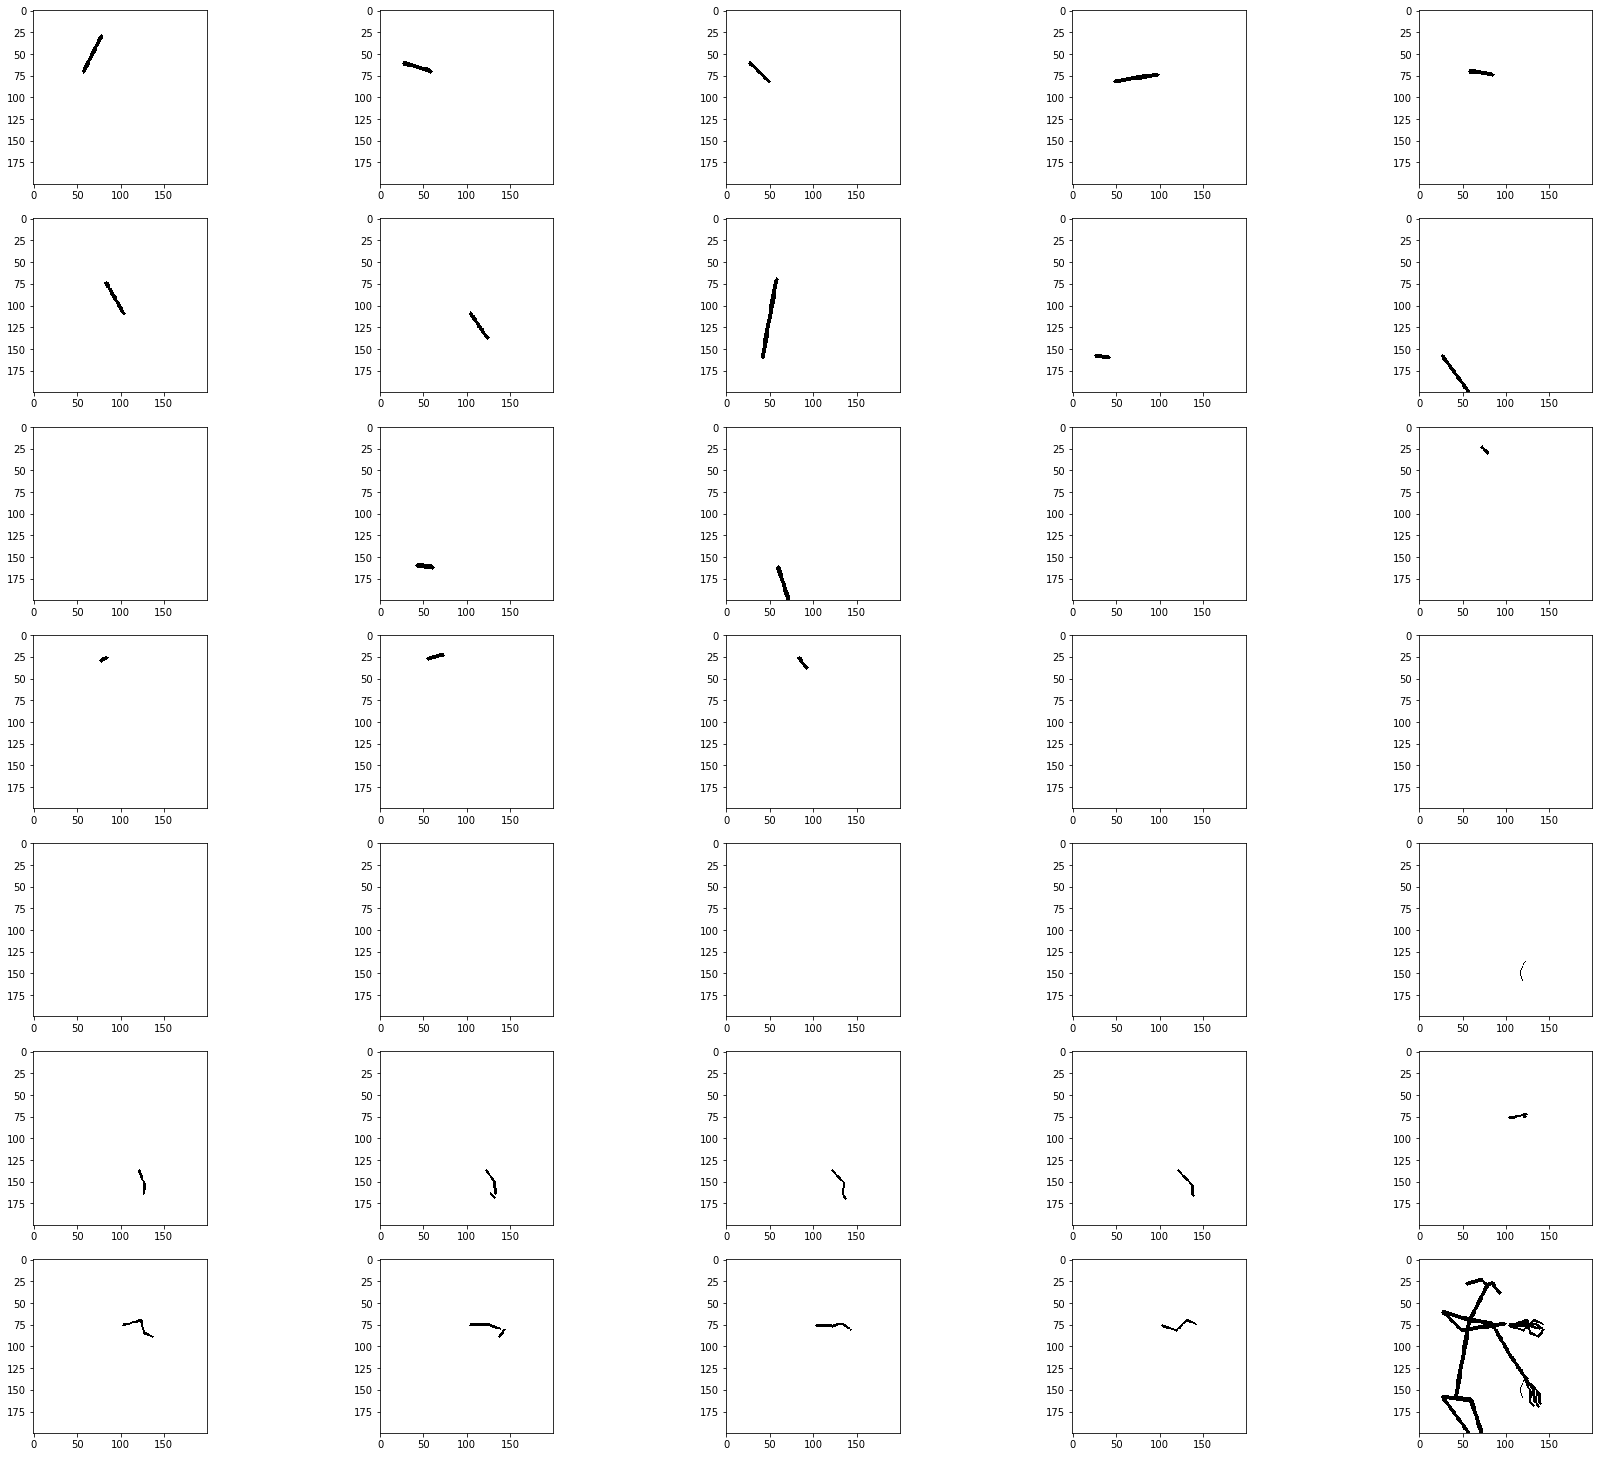

In [24]:
BATC=1
def norm_0to1(inp):
    return (inp-inp.min())/(inp.max()-inp.min())
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize=(30,30))
for ii in range(35):
    plt.subplot(8,5,ii+1)
    if ii==34:
        plt.imshow(norm_0to1(lbl_sample[BATC,ii,100:300,200:400]).detach().cpu().numpy(),"gray")
    else:
        plt.imshow(1-norm_0to1(lbl_sample[BATC,ii,100:300,200:400]).detach().cpu().numpy(),"gray")
    
plt.show()

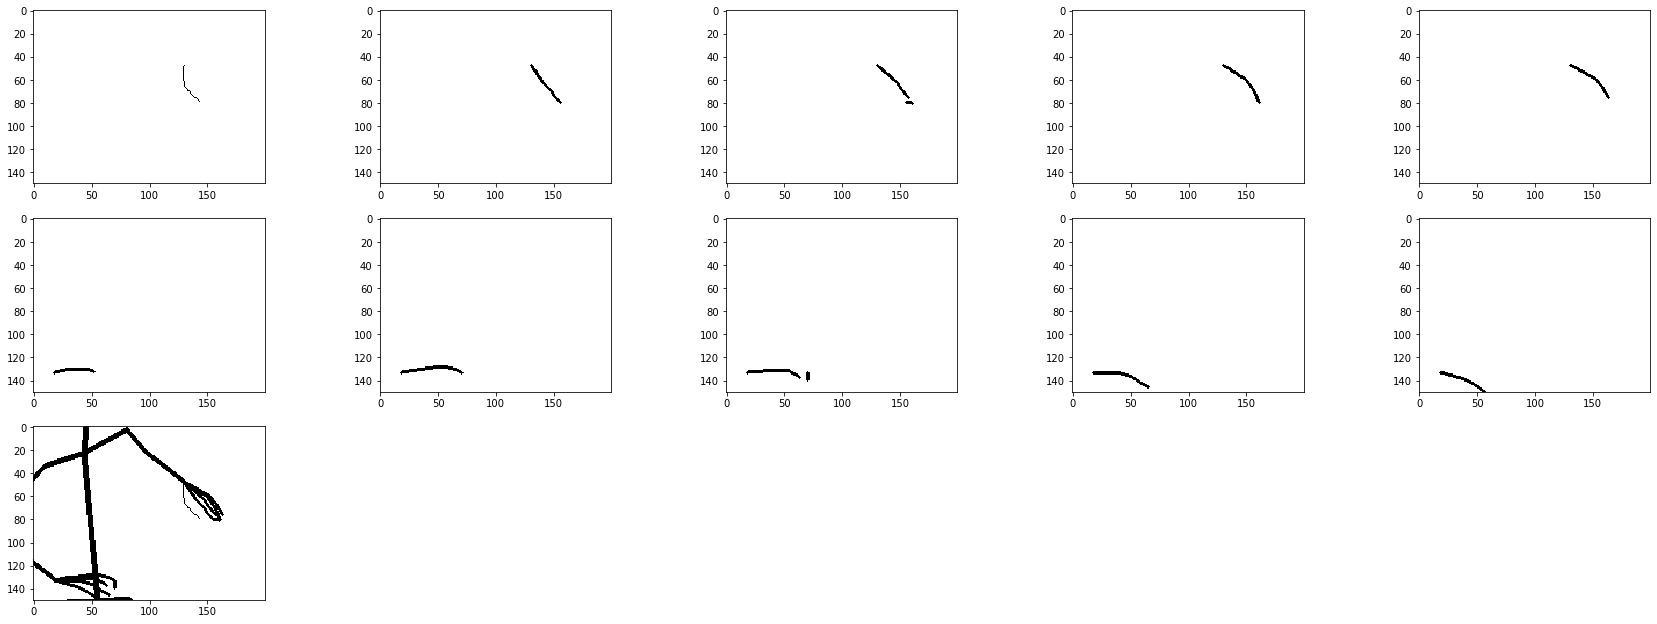

In [9]:
BATC=1
def norm_0to1(inp):
    return (inp-inp.min())/(inp.max()-inp.min())
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize=(30,30))
for ii in range(10):
    plt.subplot(8,5,ii+1)
    plt.imshow(norm_0to1(1-lbl_sample[BATC,ii+24,125:275,200:400]).detach().cpu().numpy(),"gray")
plt.subplot(8,5,ii+2)
plt.imshow(norm_0to1(lbl_sample[BATC,34,125:275,200:400]).detach().cpu().numpy(),"gray")   
plt.show()

In [7]:
import numpy as np
a=np.array([0,0])
a.any()

0

In [29]:
A=np.zeros((1,3,32,32))
B=np.zeros((1,3,32,32))
C=np.concatenate((A,B),axis=0)
C[0].shape

(3, 32, 32)

In [62]:
import torch.nn as nn
LABEL_NC=0
DATA_TYPE=32
NO_INSTANCE=True
USE_FEATURES=True
LOAD_FEATURES=False
LABEL_FEAT=False
def get_edges(t):
        edge = torch.cuda.ByteTensor(t.size()).zero_()
        edge[:,:,:,1:] = edge[:,:,:,1:] | (t[:,:,:,1:] != t[:,:,:,:-1])
        edge[:,:,:,:-1] = edge[:,:,:,:-1] | (t[:,:,:,1:] != t[:,:,:,:-1])
        edge[:,:,1:,:] = edge[:,:,1:,:] | (t[:,:,1:,:] != t[:,:,:-1,:])
        edge[:,:,:-1,:] = edge[:,:,:-1,:] | (t[:,:,1:,:] != t[:,:,:-1,:])
        if DATA_TYPE==16:
            return edge.half()
        else:
            return edge.float()
        
def encode_input(label_map, inst_map=None, real_image=None, feat_map=None, infer=False):             
    if LABEL_NC == 0:
        input_label = label_map.data.cuda()
    else:
        # create one-hot vector for label map 
        size = label_map.size()
        oneHot_size = (size[0], LABEL_NC, size[2], size[3])
        input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
        input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)
        if DATA_TYPE == 16:
            input_label = input_label.half()

    # get edges from instance map
    if not NO_INSTANCE:
        inst_map = inst_map.data.cuda()
        edge_map = get_edges(inst_map)
        input_label = torch.cat((input_label, edge_map), dim=1)         
    input_label = Variable(input_label, volatile=infer)

    # real images for training
    if real_image is not None:
        real_image = Variable(real_image.data.cuda())

    # instance map for feature encoding
    if USE_FEATURES:
        # get precomputed feature maps
        if LOAD_FEATURES:
            feat_map = Variable(feat_map.data.cuda())
        if LABEL_FEAT:
            inst_map = label_map.cuda()

    return input_label, inst_map, real_image, feat_map

In [41]:
input_label, inst_map, real_image, feat_map=encode_input(bb.sum(1).unsqueeze(1))

RuntimeError: CUDA error: device-side assert triggered

In [5]:
print(bb.shape)
print(bb.max(),bb.min())

torch.Size([10, 3, 256, 512])
tensor(255.) tensor(0.)


In [19]:
cc=bb.max(1).values.unsqueeze(1)

In [20]:
cc.shape

torch.Size([10, 1, 256, 512])

In [4]:
B=bb.view(10,3,256*512)

In [11]:
B=bb.detach().transpose(1,3).contiguous().view(10*256*512,3).numpy().copy()
print(B.shape)
print(B.max())

(1310720, 3)
255.0


In [12]:
import numpy as np
V=(B!=255).any(1)
M=np.intc(B[V,:])
M.shape

(25023, 3)

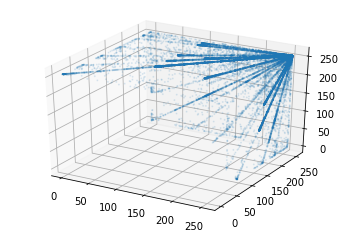

In [13]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Axes3D.scatter(ax,xs=M[:,0],ys= M[:,1], zs=M[:,2],alpha=0.1,s=1)

In [57]:
import numpy as np
M=np.intc(np.sort(M,axis=0))

In [38]:
cc.shape

(256, 512, 3)

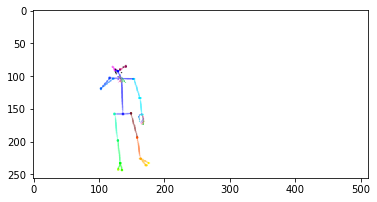

In [3]:
cc=bb[0,...].detach().numpy().copy().transpose(1,2,0)

plt.imshow(np.intc(cc))

In [8]:
bb.max(1).values.shape

torch.Size([10, 256, 512])

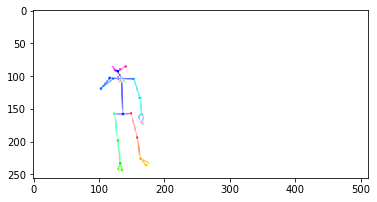

In [10]:
dd=(bb/(bb.max(1).values).unsqueeze(1))[0].detach().numpy().copy().transpose(1,2,0)
plt.imshow(dd)

In [20]:
import json
with open('../data/soldier/train_label/10_0_keypoints.json') as f:
    data = json.load(f)

In [31]:
data

{'version': 1.3,
 'people': [{'person_id': [-1],
   'pose_keypoints_2d': [642.804,
    567.404,
    0.922078,
    613.195,
    632.893,
    0.836451,
    557.512,
    616.487,
    0.709216,
    514.972,
    619.756,
    0.236318,
    534.587,
    652.523,
    0.262503,
    668.878,
    642.567,
    0.854175,
    704.889,
    695.067,
    0.779441,
    747.489,
    721.236,
    0.859093,
    560.732,
    852.5,
    0.799503,
    511.814,
    849.089,
    0.761089,
    475.589,
    1035.88,
    0.786557,
    429.615,
    1242.19,
    0.778544,
    600.072,
    865.481,
    0.716365,
    636.049,
    1055.57,
    0.801459,
    564.14,
    1225.86,
    0.761259,
    629.542,
    560.618,
    0.885496,
    659.01,
    560.623,
    0.866703,
    590.295,
    564.044,
    0.862774,
    665.745,
    563.961,
    0.059184,
    603.416,
    1304.6,
    0.704605,
    616.547,
    1297.89,
    0.785743,
    537.846,
    1245.47,
    0.721224,
    403.586,
    1314.36,
    0.687059,
    383.941,
  

In [22]:
print(data.keys())
print(data["people"][0].keys())
print("pose_keypoints_2d:",data["people"][0]["pose_keypoints_2d"].__len__())
print("face_keypoints_2d:",data["people"][0]["face_keypoints_2d"].__len__())
print("hand_left_keypoints_2d:",data["people"][0]["hand_left_keypoints_2d"].__len__())
print("hand_right_keypoints_2d:",data["people"][0]["hand_right_keypoints_2d"].__len__())

dict_keys(['version', 'people'])
dict_keys(['person_id', 'pose_keypoints_2d', 'face_keypoints_2d', 'hand_left_keypoints_2d', 'hand_right_keypoints_2d', 'pose_keypoints_3d', 'face_keypoints_3d', 'hand_left_keypoints_3d', 'hand_right_keypoints_3d'])
pose_keypoints_2d: 75
face_keypoints_2d: 210
hand_left_keypoints_2d: 63
hand_right_keypoints_2d: 63


In [30]:
jj=0

face=np.array(data["people"][jj]["face_keypoints_2d"])# *70 points
pose=np.array(data["people"][jj]["pose_keypoints_2d"])# *25 points
hand_l=np.array(data["people"][jj]["hand_left_keypoints_2d"])# *25 points
hand_r=np.array(data["people"][jj]["hand_right_keypoints_2d"])


HEAD_SIZE=64
BODY_SIZE=512
head_mtx=np.zeros((21+1,HEAD_SIZE,HEAD_SIZE))
head_cent=(int(pose[0]),int(pose[1]))
if face is not None and sum(face):
    n_face=face.__len__()//3
    face=[ int(x) for x in face ]
    head_inside=head_cent[0]>0 and head_cent[0]<BODY_SIZE \
            and head_cent[1]>0 and head_cent[1]<BODY_SIZE
    for ii in range(0,n_face):
        if face[3*ii+1]-head_cent[1]+HEAD_SIZE//2>0 and face[3*ii]-head_cent[0]+HEAD_SIZE//2 >0 \
        and face[3*ii+1]-head_cent[1]+HEAD_SIZE//2<HEAD_SIZE and face[3*ii]-head_cent[0]+HEAD_SIZE//2 <HEAD_SIZE:
            head_mtx[ii%21,face[3*ii+1]-head_cent[1]+HEAD_SIZE//2,face[3*ii]-head_cent[0]+HEAD_SIZE//2]=1
head_mtx[21,...]=np.any(head_mtx[:21,...],0)
head_mtx[21,...]=1-head_mtx[21,...]
print("head center: ",head_cent[0],head_cent[1])
print("face x:min ",min(face[0::3]),"max ",max(face[0::3]))
print("face y:min ",min(face[1::3]),"max ",max(face[1::3]))
print("face new x_:min ",min(face[0::3])-head_cent[0],"max ",max(face[0::3])-head_cent[0])
print("face new y_:min ",min(face[1::3])-head_cent[1],"max ",max(face[1::3])-head_cent[1])

head center:  642 567
face x:min  599 max  660
face y:min  546 max  609
face new x_:min  -43 max  18
face new y_:min  -21 max  42


In [28]:
import PIL
